<a href="https://colab.research.google.com/github/mkandrewhuang301/CS362/blob/main/5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **Student Names and IDs**:
>
> - Andrew Huang ah629
> - Jason Shang zs110

All homework is to be submitted through Gradescope. For each submission, you will submit both a PDF file and a Jupyter notebook. We will usually grade your PDF file only (typically we will **NOT** run your code, so make sure you have all the results are displayed correctly) and the Jupyter notebook is for backup purpose (if we see something wrong in your code).

Homework is to be done either individually or in pairs, and working in pairs is strongly encouraged: This helps you discuss concepts and get unstuck when you encounter difficulties. It also helps us return your graded work earlier, since we'll have to read fewer assignments. No other groupings are allowed.

# Homework 5

## Coding
We will use the same gif we used in homework 4 for the following questions. We will parallelize part of the exercises we did in homework 4.

76
(186, 248, 4)


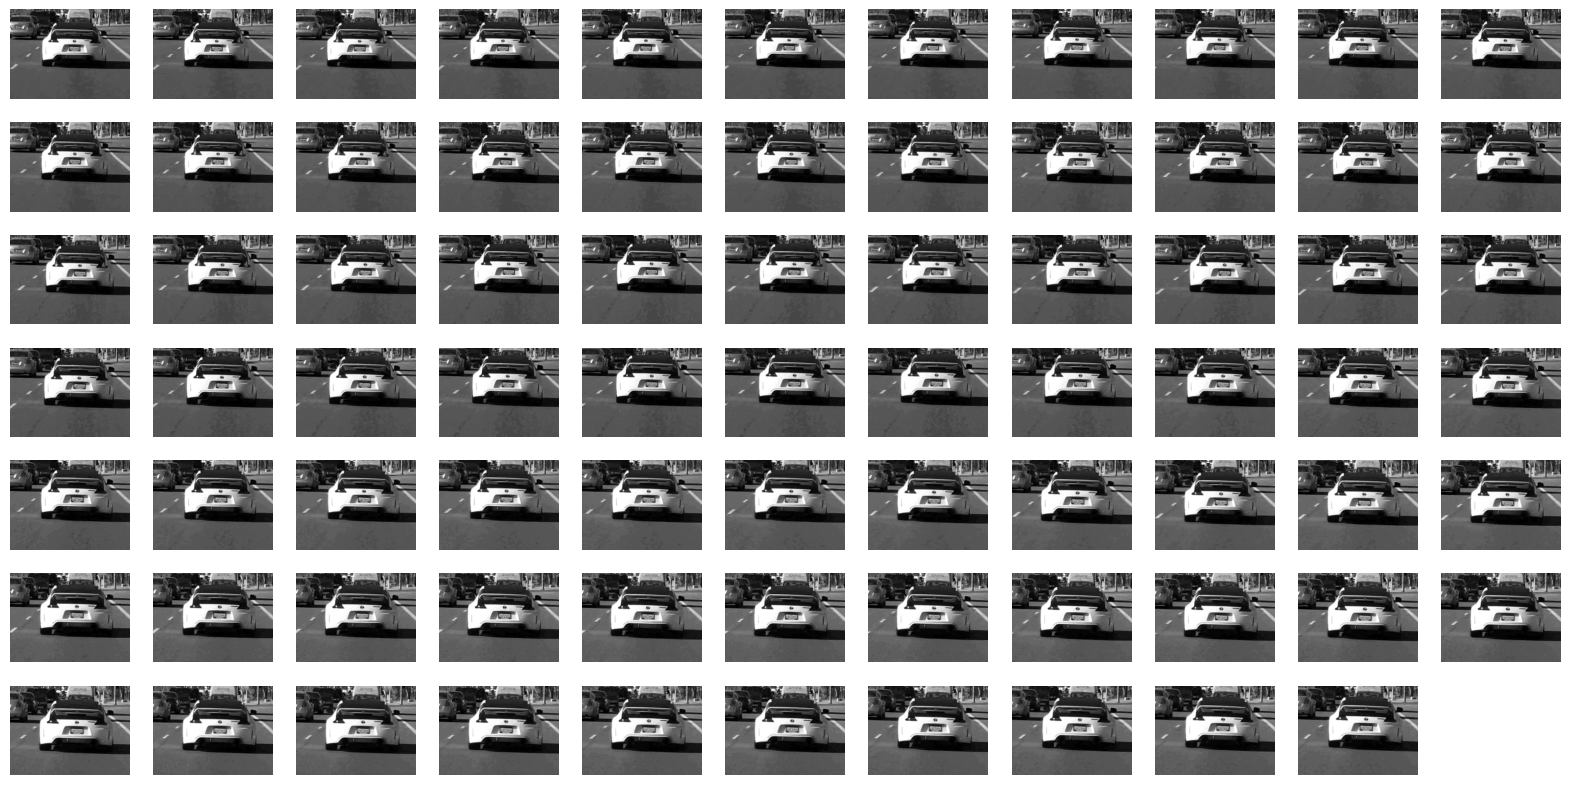

In [ ]:
import numpy as np, cv2
import matplotlib.pyplot as plt

import imageio, urllib.request

url = "https://i.stack.imgur.com/lui1A.gif"
fname = "tmp.gif"

imdata = urllib.request.urlopen(url).read()
open(fname,'wb+').write(imdata)

gif = imageio.mimread(fname)

imgs = [ cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in gif ]

print(len(gif))
print(gif[-1].shape)

fig = plt.figure(figsize=(20,10))

rows, cols = 7, 11
k = 0
for i in range(rows):

  for j in range(cols):
    while k < len(imgs):
      ax = plt.subplot(rows,cols,k+1)
      ax.imshow( imgs[k], cmap='gray' )
      ax.axis('off')
      k += 1

We will use the motion vectors we obtained in Homework 4 (question 4) to warp all the frames to the first reference frame. To get the motion vectors, you can either: 1) directly copy the results from Homework 4; or 2) copy the code you wrote in homework 4 and re-run the code to recalcualte the motion vector output. Once we have the motion vectors, instead of directly merging all frames together, we will align all frames to the reference frame first. This means, we will transform all frames (except the reference frame) based on the corresponding relative motions. Since we have 76 frames in total and the first frame is used as reference, we will align the remainder 75 frames.

## Solving for motion correction

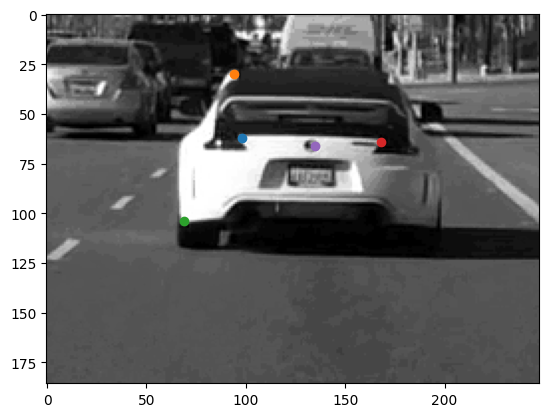

In [ ]:
features = cv2.goodFeaturesToTrack(imgs[0], 7, 0.49, 20)
plt.figure()
plt.imshow(imgs[0], cmap='gray')

for feature in features:
  plt.scatter(feature[0][0], feature[0][1])

In [ ]:
lk_params = dict(winSize = (20,20), maxLevel = 2, criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 15, 0.001))
trajectories = []
for feature in features:
  trajectories.append([(feature[0][0], feature[0][1])])

prev_features = features.copy() # set to initial features

for i in range(1, len(imgs)):
  prev, cur = imgs[i-1], imgs[i]
  next_points, status, error = cv2.calcOpticalFlowPyrLK(
      prev, cur, prev_features, None, **lk_params
  )

  if next_points is not None:
    valid_new_features = next_points[status==1]
    if (len(valid_new_features) != len(prev_features)):
      print("a feature disappeared!")

  for i in range(len(valid_new_features)):
    x, y = valid_new_features[i].ravel()
    trajectories[i].append((x, y))

  prev_features = valid_new_features.reshape(-1, 1, 2)

motion = []
orig_x, orig_y = trajectories[1][0]

for x in range(len(imgs)):
  nx, ny = trajectories[1][x]
  dx = nx - orig_x
  dy = ny - orig_y
  motion.append((dx, dy))

### Question 1
For this question, we will not use parallelism. First, write a function:

```
def align(img, motion)
```
that aligns an image to the reference based on the image translation vector (x,y) and returns the aligned image. Use this function to serially align all 75 frames with respect to the reference frame. Record the total running time.


### Answer

In [ ]:
import time

def align (img, motion):
  aligned = np.zeros_like(img, dtype='f')
  nr, nc = img.shape
  T = np.array([[1., 0., -float(motion[0])], [0., 1., -float(motion[1])]])
  aligned_frame = cv2.warpAffine( img, T, (nc,nr) )
  aligned += aligned_frame
  return aligned

start_time = time.time()
for f in range(len(imgs)):
  result = align(imgs[f], motion[f])
end_time = time.time()
total_time = end_time - start_time
print("Total runtime without parallel processing:", total_time, "seconds")

Total runtime without parallel processing: 0.07814931869506836 seconds


### Question 2
For this question, we will apply a similar parallel processing technique to the one we used in class. We will:
1. Use a pool with two workers (each process will align half the number of frames)
3. Write a helper function to align half of the images: `def partial_align( imgs, frames, motions, results )`
2. Use `multiprocessing.Manager.Queue` to store each aligned image
4. Assign tasks to the pool and run
5. Put all aligned images into a single list
6. Record the running time

Are you able to improve the running time?

### Answer

In [ ]:
import multiprocessing, os, time

def partial_align(imgs, frames, motions, results):
  for f in frames:
    aligned_img = align(imgs[f], motions[f])
    results.put(aligned_img)

start_time = time.time()
frames = len(gif)
manager = multiprocessing.Manager()
results = manager.Queue()
pool = multiprocessing.Pool(2)

pool.apply_async( partial_align, args=( imgs, range(1,39),motion, results ) )
pool.apply_async( partial_align, args=( imgs, range(39,77),motion, results ) )
pool.close()
pool.join()
aligned = []
while not results.empty():
  aligned.append(results.get())
end_time = time.time()
print("Total run time with parallel processing: ", end_time - start_time, "seconds")

Total run time with parallel processing:  0.5170531272888184 seconds


I am unable to improve the runtime because although doing each process is faster through parallel computing, the overhead of setting up the environment for parallel processing exceeds the time we would have gained from it.

### Question 3
For this question, we will apply a different parallel processing strategy to solve the same problem. To do this, we will:


1.   Use a pool with two workers
2.   Use `pool.starmap_async` and the helper function `align` we wrote in Q1 (`starmap_asyn` iterates over iterables and calls a function with the iterables unpacked). Store results in a variable (you don't have to use `manager.queue` in this case)
3.   To retrieve the final list of images, use `results.get()`
4.   Record the total running time

Is there any improvement in running time?



### Answer

In [ ]:
start_time = time.time()
frames = len(gif)
pool = multiprocessing.Pool(10)
results = pool.starmap_async(align, [(x,) for x in range(1, 100001)])
ret = results.get()
end_time = time.time()
total_time = end_time - start_time
print("Total runtime:", total_time, "seconds")

NameError: ignored

I am unable to improve the runtime because although doing each process is faster through parallel computing, the overhead of setting up the environment for parallel processing exceeds the time we would have gained from it. We can note that it is only slightly slower than the method in question 2, being only slightly slower than the distributed programming method

### Question 4
We will now evaluate how GPUs can potentially accelerate the running time. To do this, we will use pytorch and pytorch tensors. We will re-implement the phase correlation function to find translations between two images like we did in Homework 3. The two images are given below: one is called **img** and the translated one is called **img_translation**. To reimplement, we will:


1.   Convert **img_b** and **img_translation** to pytorch tensors
2.   Re-write function `def cps(img1, img2)`. Instead of using `np.fft.fft2`, we will use `torch.fft.rfft2` (please read the documentation carefully). For tensor operations, we can use `torch.multiply`, `torch.conj` and `torch.abs`. Everything else should be similar. The output of the function will be the cross power spectrum.
3.   Then, we will use `torch.fft.irfft2` to calculate the inverse Fourier transform of the cross power spectrum.  Finally, we will convert the result back to a numpy array and follow the same strategy we used in Homework 3 to get the translation vector.

We will first run the code using the CPU. To do this, set `torch.device` to "cpu" and make sure when you convert all numpy arrays to torch tensors, set tensors to the corresponding cpu device (check documentation of `torch.tensor` to do this). Record the running time.

**Note**: Similar to a numpy array, a PyTorch Tensor is a generic n-dimensional array that can be used for arbitrary numeric computations. The main difference between a numpy array and a PyTorch Tensor is that
a PyTorch Tensor can be used to run on either the CPU or GPU.



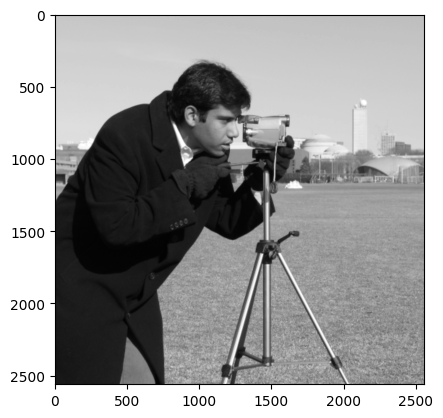

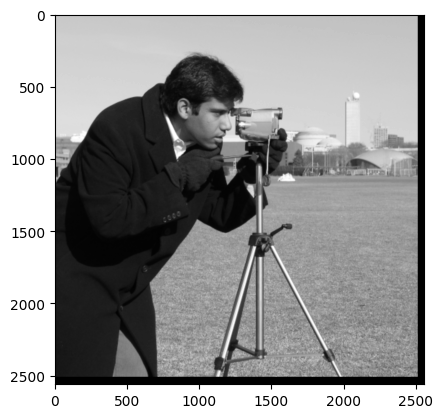

In [ ]:
from skimage import data
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import torch

img =  data.camera()
img = img/(np.max(img))

img_b = cv2.resize(img, (img.shape[1]*5,img.shape[0]*5)).astype(np.float32)
plt.figure()
plt.imshow(img_b,cmap='gray')
T = np.float32([[1, 0, -50], [0, 1, -50]])
img_translation = cv2.warpAffine(img_b, T, (img_b.shape[1], img_b.shape[0]))
img_translation = img_translation.astype(np.float32)
plt.figure()
plt.imshow(img_translation,cmap='gray')

### Answer

In [ ]:
def cps(img1, img2):
  f1 = torch.fft.rfft2(img1)
  f2 = torch.fft.rfft2(img2)
  return torch.mul(f1, torch.conj(f2))/torch.abs(torch.mul(f1, f2) + 1e-10)

In [ ]:
start_time = time.time()
img_b_tensor = torch.from_numpy(img_b).to(device=torch.device('cpu'))
img_translation_tensor = torch.from_numpy(img_translation).to(device=torch.device('cpu'))

cps_signal = cps(img_b_tensor, img_translation_tensor)

ifft_cps_signal_tensor = torch.fft.irfft2(cps_signal)
ifft_cps_signal = ifft_cps_signal_tensor.numpy()
max = np.max(ifft_cps_signal)
coordinates = np.where(ifft_cps_signal == max)
maxx, maxy = coordinates[1][0], coordinates[0][0]
end_time = time.time()

In [ ]:
print("Coordinates: (", maxx, ", ", maxy, ")")
print("Total time when running on CPU: ", end_time - start_time, " seconds")

Coordinates: ( 50 ,  50 )
Total time when running on CPU:  0.5421898365020752  seconds


### Question 5:
We will now run everything in the GPU. To use GPUs in google colab, go to **Edit -> Notebook settings -> Hardware acceleration: GPU**. Now, instead of setting ``torch.device`` to "cpu", set it to "cuda:0". Re-run the code and record the running time. Is there any improvement in running time?

**Note**: When you convert a GPU tensor to a numpy array, you will have to convert it back to a CPU tensor first.

### Answer

In [ ]:
start_time = time.time()
img_b_tensor = torch.from_numpy(img_b).to(device=torch.device('cuda:0'))
img_translation_tensor = torch.from_numpy(img_translation).to(device=torch.device('cuda:0'))

cps_signal = cps(img_b_tensor, img_translation_tensor)

ifft_cps_signal_tensor = torch.fft.irfft2(cps_signal)
ifft_cps_signal = ifft_cps_signal_tensor.to(device=torch.device('cpu')).numpy()
max = np.max(ifft_cps_signal)
coordinates = np.where(ifft_cps_signal == max)
maxx, maxy = coordinates[1][0], coordinates[0][0]
end_time = time.time()

In [ ]:
print("Coordinates: (", maxx, " ", maxy, ")")
print("Total time when running on GPU: ", end_time - start_time, " seconds")

Coordinates: ( 50   50 )
Total time when running on GPU:  0.0500493049621582  seconds


Using the GPU, the runtime improved quite significantly.